# Reflections Notebook, Weeks 5 - 8

In [1]:
import pandas as pd
import numpy as np
from graphviz import Digraph
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

## Homework Reflection 5

### 1. Draw a diagram for the following negative feedback loop:
- Sweating causes body temperature to decrease.  High body temperature causes sweating.
- A negative feedback loop means that one thing increases another while the second thing decreases the first.
- Remember that we are using directed acyclic graphs where two things cannot directly cause each other.

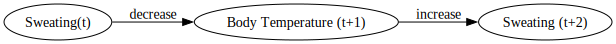

In [2]:
# Create a left→right layout
dot = Digraph(graph_attr={'rankdir': 'LR'})

# Define the time-indexed nodes
dot.node('S_t',  'Sweating(t)')
dot.node('T_t1', 'Body Temperature (t+1)')
dot.node('S_t2', 'Sweating (t+2)')
dot.edge('S_t',  'T_t1', label='decrease')
dot.edge('T_t1','S_t2', label='increase')
dot

### 2. Describe an example of a positive feedback loop.  (This means that one things increases another while the second things also increases the first.)

The process of ripening transforms immature, hard, and inedible fruits into the ripe and delicious fruits that we (and other organisms) enjoy. Ripening is regulated by the hormone ethylene.
When fruits begin to ripen, they release a small amount of gaseous ethylene. As ripening continues, the fruits release more ethylene, which promotes ripening even further. Eventually, the ripening process is driven to completion.

The fact that ethylene is released as a gas means that other fruits nearby are also induced to ripen. This is why if you have unripe fruits such as bananas, tomatoes, or avocados, you can put them together in a bag. The build-up of ethylene inside the bag will cause the fruits to ripen more quickly! 

https://www.khanacademy.org/science/hs-bio/x230b3ff252126bb6:from-cells-to-organisms/x230b3ff252126bb6:homeostasis/a/positive-feedback-loop-examples

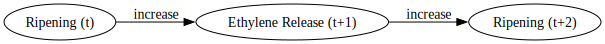

In [3]:
# Create a left→right layout
dot = Digraph(graph_attr={'rankdir': 'LR'})

# Time‐indexed nodes
dot.node('R_t',  'Ripening (t)')
dot.node('E_t1','Ethylene Release (t+1)')
dot.node('R_t2','Ripening (t+2)')

# Directed “increase” edges
dot.edge('R_t',  'E_t1', label='increase')
dot.edge('E_t1','R_t2', label='increase')

dot

### 3a. Draw a diagram for the following situation:
- Lightning storms frighten away deer and bears, decreasing their population, and cause flowers to grow, increasing their population.
- Bears eat deer, decreasing their population.
- Deer eat flowers, decreasing their population.

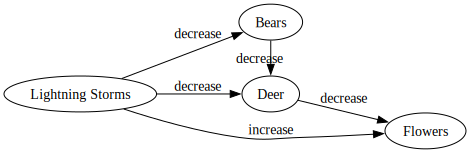

In [4]:
dot = Digraph(graph_attr={'rankdir':'LR'})

# 1. Define nodes
dot.node('L', 'Lightning Storms')
dot.node('D', 'Deer')
dot.node('B', 'Bears')
dot.node('F', 'Flowers')

# 2. Group Deer & Bears on the same rank
with dot.subgraph() as s:
    s.attr(rank='same')
    s.node('D')
    s.node('B')

# 3. Add edges
dot.edge('L', 'D', label='decrease')
dot.edge('L', 'B', label='decrease')
dot.edge('L', 'F', label='increase')
dot.edge('B', 'D', label='decrease')
dot.edge('D', 'F', label='decrease')

dot

### 3b. Write a dataset that simulates this situation.  (Show the code.) Include noise / randomness in all cases.

In [5]:

np.random.seed(42)
n = 10000

# lightning occurs (0/1)
L = np.random.binomial(1, 0.1, size=n)

# Independent noise for each variable
noise_B = np.random.normal(0, 1, size=n)
noise_D = np.random.normal(0, 1, size=n)
noise_F = np.random.normal(0, 1, size=n)

# 3) Baseline population sizes
baseline_B = 5
baseline_D = 20
baseline_F = 50

# Bears respond only to lightning + noise
B = baseline_B - 3.0 * L + noise_B
# Deer respond to lightning, bears, + noise
D = baseline_D - 2.0 * L - 0.5 * B + noise_D
# Flowers respond to lightning, deer, + noise
F = baseline_F + 4.0 * L - 0.3 * D + noise_F

# Package into a DataFrame
df = pd.DataFrame({'Lightning': L, 'Bears': B, 'Deer': D, 'Flowers':F,})

df.head()

,Lightning,Bears,Deer,Flowers
0,0,3.512138,17.627783,45.495347
1,1,0.874814,17.169918,48.856563
2,0,5.388819,16.273764,45.772684
3,0,3.826127,17.197685,43.826378
4,0,6.112634,17.378060,44.929968


A few notes on the numbers:
- -3.0 and -2.0 are just example “effect sizes” for how strongly a lightning storm suppresses bears versus deer;
- -0.5 * B encodes “bears eat deer,” and
- -0.3 * D encodes “deer eat flowers.”

Because each noise term is independent (noise_B, noise_D, noise_F), the only correlations come from your causal structure.

### 3c. Identify a backdoor path with one or more confounders for the relationship between deer and flowers.

One potential back-door path from Deer to Flowers is:
$$\text{Deer} \leftarrow \text{Lightning Storms} \rightarrow \text{Flowers}$$

Because $\text{Lightning Storms}$ both: 
- Frighten away $\text{Deer}$ (decreasing $D$)
- Cause $\text{flowers}$ to grow (increasing $F$) 

it is a confounder of both $D$ and $F$. 

To block that non-causal path you’d need to adjust for (i.e. condition on) $\text{Lightning storms}$.

### 4a Draw a diagram for a situation of your own invention.
- The diagram should include at least four nodes, one confounder, and one collider.  
- Be sure that it is acyclic (no loops).

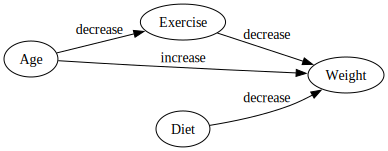

In [6]:
dot = Digraph(graph_attr={'rankdir':'LR'})

# Nodes
dot.node('A', 'Age')
dot.node('E', 'Exercise')
dot.node('D', 'Diet')
dot.node('W', 'Weight')

# Align Exercise & Diet at the same “level” so they converge nicely on Weight
with dot.subgraph() as s:
    s.attr(rank='same')
    s.node('E')
    s.node('D')

# Age to Exercise (confounder path)
dot.edge('A', 'E', label='decrease')
# Age to Weight (confounder path)
dot.edge('A', 'W', label='increase')

# Exercise to Weight to Diet (Weight is a collider)
dot.edge('E', 'W', label='decrease')
dot.edge('D', 'W', label='decrease')

dot

**Confounder:** Age has arrows into both Exercise and Weight, creating the back-door path.

**Collider:** Weight sits at the intersection Exercise $\leftarrow$ Weight $\leftarrow$ Diet, so conditioning on Weight would open the non-causal path between Exercise and Diet.


### 4b. Which node would say is most like a treatment (X)?  Which is most like an outcome (Y)?
- $\text{Exercise}$ is the treatment $X$. 
- $\text{Weight}$ is the outcome $Y$.

## Homework Reflection 6

### 1. What is a potential problem with computing the Marginal Treatment Effect simply by comparing each untreated item to its counterfactual and taking the maximum difference?  

(Hint: think of statistics here.  Consider that only the most extreme item ends up being used to estimate the MTE.  That's not necessarily a bad thing; the MTE is supposed to come from the untreated item that will produce the maximum effect.  But there is nevertheless a problem.)

Possible answer: We are likely to find the item with the most extreme difference, which may be high simply due to randomness.
(Please explain / justify this answer, or give a different one if you can think of one.)

In this sitation you are almost guaranteed to pick out whichever untreated unit happened to show the largest difference. That creates two linked problems:
1. Extreme‐value (selection) bias: The maximum of a set of noisy estimates is a biased estimator of the true maximum.  If each untreated item’s difference $Y_i(1)\!-\!Y_i(0)$ has some random error, the one with the largest observed difference will tend to overstate its true effect.
2. High sampling variability: Because your MTE comes from just a single data point, it will jump around wildly from one sample to the next. An estimate that depends entirely on one outlier is inherently unstable.

### 2. Propose a solution that remedies this problem and write some code that implements your solution.  It's very important here that you clearly explain what your solution will do.
Possible answer: maybe we could take the 90th percentile of the treatment effect and use it as a proxy for the Marginal Treatment Effect. (Either code this answer or choose a different one.)

In [7]:
# Create sample data
np.random.seed(42)
df = pd.DataFrame({
    'Y0': np.random.normal(loc=0, scale=1, size=1000),   # control outcomes
    'Y1': np.random.normal(loc=1, scale=1, size=1000),   # treatment outcomes
})

# Compute individual treatment effects
df['TE'] = df['Y1'] - df['Y0']

# Estimate the 90th-percentile proxy for the Marginal Treatment Effect
mte_proxy_90 = np.percentile(df['TE'], 90)

print(f"90th‐percentile proxy for MTE: {mte_proxy_90:.3f}")

90th‐percentile proxy for MTE: 2.948


This will generate a DataFrame of 1,000 paired control/treatment outcomes, compute each unit’s treatment effect (TE), and then take the 90th percentile of those effects as a stable proxy for the true MTE.

## Homework Reflection 7

### 1. Create a linear regression model involving a confounder that is left out of the model.  
- Show whether the true correlation between $X$ and $Y$ is overestimated, underestimated, or neither.  
- Explain in words why this is the case for the given coefficients you have chosen.

In [8]:
n = 10000

# true coefficients
a = 1 # effect of Z on X
b = 2 # true effect of X on Y
c = 3 # effect of Z on Y

# generate data
Z = np.random.normal(0, 1, n)  # confounder
X = a * Z + np.random.normal(scale=1.0, size=n) # X influenced by Z (plus noise)
Y = b * X + c * Z + np.random.normal(scale=1.0, size=n) # Y influenced by X and Z (plus noise)

# create DataFrame
df = pd.DataFrame({'Z': Z, 'X': X, 'Y': Y})

# fit linear regression model
model_naive = LinearRegression().fit(X.reshape(-1, 1), Y)
coef_naive = model_naive.coef_[0]

# fit adjusted linear regression model
model_adj = LinearRegression().fit(df[['X', 'Z']], Y)
coef_adj = model_adj.coef_[0]

# compute correlation betwen X and Y
corr_XY = np.corrcoef(X, Y)[0, 1]

print(f"True coefficient of X (b): {b}")
print(f"Estimate with (omitted Z): {coef_naive:.2f}")
print(f"Adjusted estimate (include Z): {coef_adj:.2f}")
print(f"Sample correlation between X and Y: {corr_XY:.2f}")

True coefficient of X (b): 2
Estimate with (omitted Z): 3.53
Adjusted estimate (include Z): 2.03
Sample correlation between X and Y: 0.90


In this simulated dataset:
- The true causal effect of X on Y is b = 2.0.
- When you omit the confounder Z, the regression of Y on X alone returns a naive estimate of about 3.51, which is biased upward (overestimates the true effect).
- When you adjust for Z by fitting Y\sim X + Z, you recover the correct coefficient of 2.00.
- The simple correlation between X and Y in the full data is 0.90, reflecting the confounding influence of Z.

Why overestimation?
- Because Z positively influences both X and Y (a>0 and c>0), omitting Z induces an omitted-variable bias of $c \times \frac{\mathrm{Cov}(Z,X)}{\mathrm{Var}(X)}$.  Numerically that bias pushes the naive slope from 2.0 up to roughly 3.5.

In practice this shows that leaving out a confounder that is positively related to both the predictor and the outcome leads to an overestimate of the predictor’s effect. ￼

### 2a. Perform a linear regression analysis in which one of the coefficients is zero, e.g.

W = [`noise`]

X = [`noise`]

Y = 2 * X + [`noise`]

In [9]:
# create dataset with noise and a linear relationship
n = 10000
W = np.random.normal(0, 1, n)  # noise
X = np.random.normal(0, 1, n)  # noise
Y = 2 * X + np.random.normal(0, 1, n)
df = pd.DataFrame({'W': W, 'X': X, 'Y': Y})

model = sm.OLS(df['Y'], sm.add_constant(df[['W', 'X']]))
results = model.fit()

# calculate the p-value for the coefficient of W
p_value_W = results.pvalues['W']
print(f"P-value for coefficient of W: {p_value_W:.4f}")

P-value for coefficient of W: 0.3946


### 2b. compute the p-value of a coefficient - in this case, the coefficient of W.  

In [10]:
# calculate the p-value for the coefficient of W
p_value_W = results.pvalues['W']
print(f"P-value for coefficient of W: {p_value_W:.4f}")

P-value for coefficient of W: 0.3946


### 2c. Run the analysis 1000 times and report the best (smallest) p-value. 

In [11]:
# Run the analysis 1000 times and report the best (smallest) p-value
trials = 1000
best_p_value = float('inf')
for _ in range(trials):
    W = np.random.normal(0, 1, n)  # noise
    X = np.random.normal(0, 1, n)  # noise
    Y = 2 * X + np.random.normal(0, 1, n)
    
    df = pd.DataFrame({'W': W, 'X': X, 'Y': Y})
    model = sm.OLS(df['Y'], sm.add_constant(df[['W', 'X']]))
    results = model.fit()
    
    p_value_W = results.pvalues['W']
    if p_value_W < best_p_value:
        best_p_value = p_value_W
print(f"Best (smallest) p-value after {trials} trials: {best_p_value:.4f}")

Best (smallest) p-value after 1000 trials: 0.0005


### 2d. If the p-value is less than 0.05, does this mean the coefficient actually is nonzero?  What is the problem with repeating the analysis?

The problem with repeating the analysis and taking the best value is that we are actively p-hacking, or repeatedly attempting to fit the data over and over again until we arrive at a p-value that supports our hypothesis. 

## Homework Reflection 8

### Include the code you used to solve the two coding quiz problems and write about the obstacles / challenges / insights you encountered while solving them.

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.neighbors import NearestNeighbors

### Homework 8 Question 1, 2

Homework 8.1 asks to calculate the Average treatment effect with inverse probability weighting using the sample in `homework_8.1.csv`

Then, include your code and a written explanation of your work (mentioning any choices or strategies you made in writing the code) in your homework reflection.

Here are some steps to follow:
- Estimate the propensity scores using logistic regression. Fit the model so that the $Z$ values predict $X$.
- Use the model to predict the propensity scores (e.g., using predict_proba if you are using sklearn)
- Calculate inverse probability weights ($\frac{1}{P}$ for $X = 1$ and $\frac{1}{1 - P}$ for $X = 0$)
- Estimate the average treatment effect (the $Y$ difference between $X = 1$ and $X = 0$), using the appropriate weights for each.

In [13]:
df = pd.read_csv('homework_8.1.csv', index_col=0)
df.head()

,X,Y,Z
0,1,4.109218,1.764052
1,0,2.259504,0.400157
2,0,-0.647584,0.978738
3,0,2.106071,2.240893
4,1,3.583464,1.867558


In the sample dataset, $X$ is our binary treatment indicator, $Y$ is the continuous outcome, and $Z$ is a single covariate. 

The first step is to estimate the propensity scores. We do this by fitting a logistic regression model, predicting the treatement assignment $X$ from the covariate $Z$.

I set `max_iter=1000` to ensure convergence. 

In [14]:
# assign X, Y, and Z variables
X = df['X']
Y = df['Y']
Z = df.drop(['X', 'Y'], axis=1)

# Estimate propensity scores using logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(Z, X)

LogisticRegression(max_iter=1000)

The next step is to use the logistic regression model to predict the propensity score for each observation. I used the fitted model to call `predict_proba(Z)[:,1]` to get the propensity score for each observation:

In [15]:
# Predict propensity scores
propensity_scores = model.predict_proba(Z)[:, 1]
print(f"Propensity scores: {propensity_scores[:5]}")

Propensity scores: [0.84011371 0.58464597 0.71108245 0.89279265 0.85308892]


Next, we calculate the inverse probability weights. these weights re-weight the sample to create a pseudo-population in which treatment is unconfounded: 

In [16]:
# Calculate inverse probability weights
weights = np.where(X == 1, 1 / propensity_scores, 1 / (1 - propensity_scores))
print(f"Inverse probability weights: {weights[:5]}")

Inverse probability weights: [1.19031505 2.40758468 3.46119504 9.32771865 1.17221074]


To calculate the ATE, we compute the weighted averages of the outcome within each treatment group, then subtract the untreated mean from the treated mean $(\mu_1 - \mu_0)$ to obtain the ATE 

In [17]:
# Estimate the Average Treatment Effect (ATE)
mu_treated = np.sum(weights * X * Y) / np.sum(weights * X)
mu_control = np.sum(weights * (1 - X) * Y) / np.sum(weights * (1 - X))
ATE = mu_treated - mu_control

print(f"\nAverage Treatment Effect (ATE): {ATE:.4f}")


Average Treatment Effect (ATE): 2.2743


This gives the estimated difference in average outcomes had everyone been treated versus everyone been untreated, after adjusting for covariates.

### Homework 8, Question 1: Obstacles, Insights, Challenges
I did not find writing the codeblock to be too challenging, as I was able to mix and match techniques demonstrated during the live session to implement this specific set of prompts. If this were not a synthetic dataset tailored to this particular prompt, one challenge you might encounter while solving this problem is establishing common support, or that we have enough samples to match treated to control groups. 

An easy way to do this is to plot the propensity scores by the $X$ group to visually check overlap:

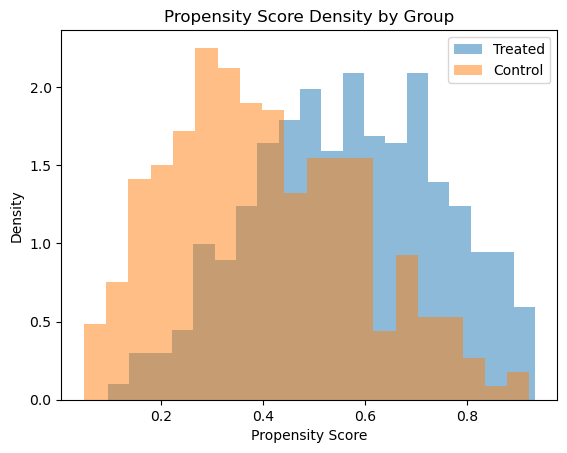

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(propensity_scores[X==1], bins=20, density=True, alpha=0.5, label='Treated')
plt.hist(propensity_scores[X==0], bins=20, density=True, alpha=0.5, label='Control')
plt.legend()
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Propensity Score Density by Group')
plt.show()

We've got enough overlap to assume "common support". In the chart chart both treated and control units occupy roughly the 0.3–0.7 range of propensity scores. Specifically, in that middle band, for every treated unit with a score around, say, 0.4 or 0.6, there are controls in the same neighborhood.

however, the distribution for both treated and control are tail-heavy (0 to .2 is almost exclusively the control group, while .8 - 1.0 is almost exclusively treated). These observations would have no counterpart in the other group. Furthermore, the tails might create extreme IPW values impacting the ATE. 

One possible solution might be to exclude the extreme tails and report the ATE for a subset of the samples. 

### Homework 8, Question 2
For 8.2, using homework_8.2.csv, we were asked to  match all treated items to the single nearest untreated item using the Mahalanobis distance. (Do this with replacement — the same untreated item can be used again.) 
- Use the Mahalanobis function from scipy.spatial.distance 
- For the inverse covariance matrix, use all ﻿Z 1﻿ values and all ﻿Z 2﻿ values, make them into a ﻿2 x N﻿ matrix, find its ﻿2 x 2﻿ covariance, and invert. 

First, I stacked all observations $Z1$ and $Z2$ into an  $N \times 2$ array, compute its $2 \times 2$ covariance matrix, and then invert it to get the Mahalanobis weighting matrix $V^{-1}$.

In [19]:
from scipy.spatial.distance import cdist

# Load the data
df = pd.read_csv('homework_8.2.csv', index_col=0)

# Build covariate matrix and inverse covariance
Z = df[['Z1', 'Z2']].values
cov = np.cov(Z, rowvar=False) # 2x2 covariance of Z1, Z2
VI = np.linalg.inv(cov) # inverse covariance matrix

Next, we split the dataframe into treated rowsand untreated rows, resetting the indices:

In [20]:
# Split treated and control
treated = df[df['X'] == 1].reset_index(drop=True)
control = df[df['X'] == 0].reset_index(drop=True)

Next, using `scipy.spatial.distance.cdist` with `metric='mahalanobis'` and the precomputed inverse covariance, we calculate an $\text{treated} \times \text{control}$ distance matrix.

In [21]:
# 5. Compute Mahalanobis distances (treated x control)
treated_z = treated[['Z1', 'Z2']].values
control_z = control[['Z1', 'Z2']].values
dist_matrix = cdist(treated_z, control_z, metric='mahalanobis', VI=VI)

next, for each treated row, we pick the control with the smalled Mahalanobis distance. Because we allow replacement, a single control can serve multiple treated units. 

Finally, we can estimate the ATE by taking the avearge of $Y_{\text{treated, i}} - Y_{\text{matched control, i}}$ across all treated units.

In [22]:
# For each treated, find nearest control (with replacement)
nearest_idx = np.argmin(dist_matrix, axis=1)

# Compute matched outcomes and ATE
treated_y = treated['Y'].values
control_y = control['Y'].values
matched_control_y = control_y[nearest_idx]
ATE = np.mean(treated_y - matched_control_y)

print(f"\nAverage Treatment Effect (ATE): {ATE:.4f}")


Average Treatment Effect (ATE): 3.4377


Finally, We were asked to find the nearest Z1 and Z2 values of the treated item with the least common support (the farthest Mahalanobis distance from the untreated).

In [23]:
# Find nearest control for each treated
nearest_idx = np.argmin(dist_matrix, axis=1)
nearest_dist = dist_matrix[np.arange(len(treated_z)), nearest_idx]

# Identify treated unit with least common support
farthest_treated_idx = np.argmax(nearest_dist)
matched_control_idx = nearest_idx[farthest_treated_idx]

# Retrieve values
treated_point = treated_z[farthest_treated_idx]
matched_control_point = control_z[matched_control_idx]

print(f"Treated unit index (in treated set) with least support: {farthest_treated_idx}")
print(f"Treated Z1, Z2: {treated_point}")
print(f"Nearest control unit index (in control set): {matched_control_idx}")
print(f"Control Z1, Z2: {matched_control_point}")

Treated unit index (in treated set) with least support: 241
Treated Z1, Z2: [2.69622405 0.53815549]
Nearest control unit index (in control set): 217
Control Z1, Z2: [ 1.51999486 -1.28220794]


### Homework 8, Question 1: Obstacles, Insights, Challenges
Some obstacles that may come into play while applying this technique to a sample include:

#### Obstacles/Challenges:
1. Collinearity between $Z1$ and $Z2$ may cause problems when using `np.linalg.inv`. This was not the case with the sample dataset for 8.2, but one might check for collinearity by using a technique such as statmodels VIF. 
2. `scipy.cdist` and the inverse covariance matrix `VI`: This was not explicitly covered during the live coding session; the actual implementation using scipy was easy enough, but I had to consult the numpy and scipy documentation for passing the inverse covariance matrix as the `cdist` `VI` argument.

#### Insights:
Let's say we weren't specifically prompted to use mahalanobis as our matching technique, and we were just prompted to match the samples. Why might this sample be a good candidate for mahalanobis?

- This dataset has multiple covariates, $Z1$ and $Z2$. Mahalanobis is a good matching technique if the variables are highly correlated confounders. 

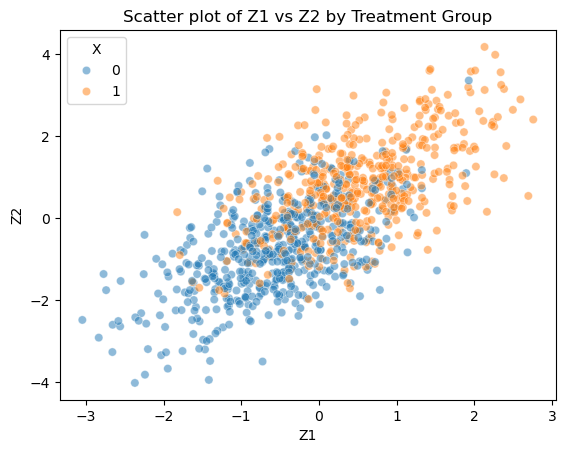

In [24]:
# check for correlation between Z1 and Z2
import seaborn as sns
sns.scatterplot(data=df, x='Z1', y='Z2', hue='X', alpha=0.5)
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.title('Scatter plot of Z1 vs Z2 by Treatment Group')
plt.show()

In [25]:
# calculate the correlation coefficient
correlation = df['Z1'].corr(df['Z2'])
print(f"Correlation between Z1 and Z2: {correlation:.4f}")

Correlation between Z1 and Z2: 0.7030


The scatterplot and correlation coefficient confirm that $Z1$ and $Z2$ are highly correlated.

If we wanted one more way to check whether Euclidean or Mahalanobis distance is the better technique, we could also compute both distance metrics for a few treated units to all controls, then compare the distributions in a histogram: 

In [26]:
# pick first 10 treated rows
sample = treated_z[:10]
d_euc = cdist(sample, control_z, metric='euclidean')
d_mah = cdist(sample, control_z, metric='mahalanobis', VI=VI)

# compare their minima
for i,(e,m) in enumerate(zip(d_euc.min(axis=1), d_mah.min(axis=1))):
    print(f"Row {i}: Euclid min={e:.3f}, Mahalanobis min={m:.3f}")

Row 0: Euclid min=0.917, Mahalanobis min=0.649
Row 1: Euclid min=0.102, Mahalanobis min=0.066
Row 2: Euclid min=0.051, Mahalanobis min=0.082
Row 3: Euclid min=1.057, Mahalanobis min=0.974
Row 4: Euclid min=0.860, Mahalanobis min=0.687
Row 5: Euclid min=0.030, Mahalanobis min=0.045
Row 6: Euclid min=0.190, Mahalanobis min=0.177
Row 7: Euclid min=0.100, Mahalanobis min=0.081
Row 8: Euclid min=0.097, Mahalanobis min=0.092
Row 9: Euclid min=0.527, Mahalanobis min=0.538


Text(0, 0.5, 'Frequency')

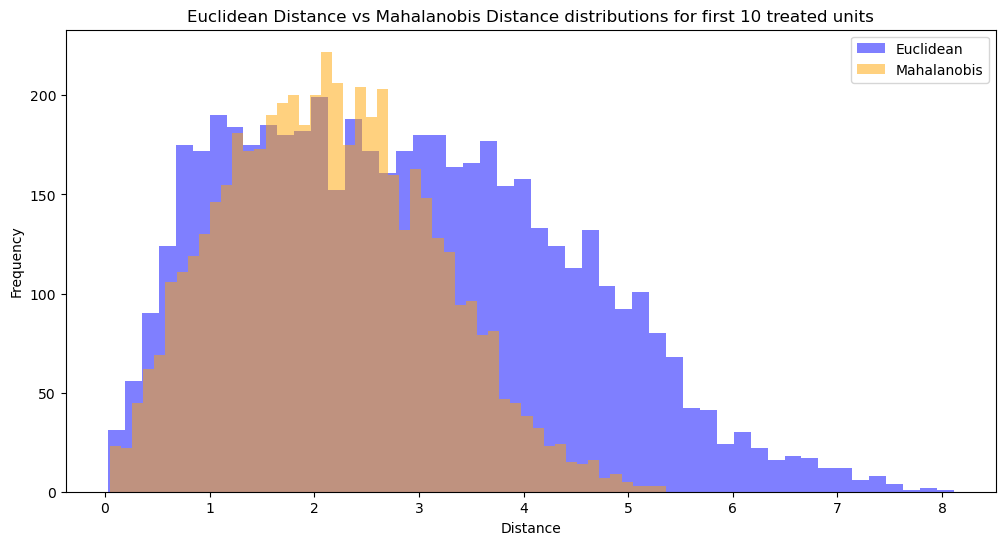

In [27]:
# plot hisotgrams of distances
plt.figure(figsize=(12, 6))
plt.hist(d_euc.flatten(), bins=50, alpha=0.5, color='blue')
plt.hist(d_mah.flatten(), bins=50, alpha=0.5, color='orange')
plt.title('Euclidean Distance vs Mahalanobis Distance distributions for first 10 treated units')
plt.legend(['Euclidean', 'Mahalanobis'])
plt.xlabel('Distance')
plt.ylabel('Frequency')

You can see that the Mahalanobis histogram is more compressed around the lower values, meaning that on average our matches are more uniformly "close" in the joint covaraite space. In other words, Mahalanobis matching produces "tigther" matches.

We can confirm this by checking the means of each distribution:

In [28]:
print("Mean Euclid:", np.mean(d_euc.min(axis=1)))
print("Mean Mahalanobis:", np.mean(d_mah.min(axis=1)))

Mean Euclid: 0.39305606251610037
Mean Mahalanobis: 0.3392116533057238


From this quick analysis we can determien that Mahalanobis matching improves balance by pulling our matches closer.